# Segmenting Lung X-ray Images with the Segment Anything Model
### Advanced Deep Learning 2022
Notebook written by [Jakob Ambsdorf](mailto:jaam@di.ku.dk).
Lung x-ray code originally written by Mathias Perslev. It has been changed slightly by Christian Igel and subsequently slightly updated [Stefan Sommer](mailto:sommer@di.ku.dk).
SAM related code (c) Meta Platforms, Inc. and affiliates.

We consider the data described in:
Bram van Ginneken, Mikkel B. Stegmann, Marco Loog. [Segmentation of anatomical structures in chest radiographs using supervised methods: a comparative study on a public database](https://doi.org/10.1016/j.media.2005.02.002). *Medical Image Analysis* 10(1): 19-40, 2006

## Object masks from prompts with SAM

The Segment Anything Model (SAM) predicts object masks given prompts that indicate the desired object. The model first converts the image into an image embedding that allows high quality masks to be efficiently produced from a prompt.

The `SamPredictor` class provides an easy interface to the model for prompting the model. It allows the user to first set an image using the `set_image` method, which calculates the necessary image embeddings. Then, prompts can be provided via the `predict` method to efficiently predict masks from those prompts. The model can take as input both point and box prompts, as well as masks from the previous iteration of prediction.

## Environment Set-up

If running locally using jupyter, first install `segment_anything` in your environment using the [installation instructions](https://github.com/facebookresearch/segment-anything#installation) in the repository. If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'.

In [1]:
using_colab = False

In [2]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

    !mkdir images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/groceries.jpg

    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

## Set-up

Necessary imports and helper functions for displaying points, boxes, and masks.

In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [4]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))


# Download model checkpoint
The checkpoint is 2.39GB, takes a few minutes for most bandwidths

In [5]:
import urllib.request
import os
from tqdm import tqdm

url = "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth"
filename = "sam_vit_h_4b8939.pth"
folder = "models"

os.makedirs(folder, exist_ok=True)

filepath = os.path.join(folder, filename)

if not os.path.exists(filepath):
    # Get the file size before downloading
    file_size = int(urllib.request.urlopen(url).info().get("Content-Length", -1))

    # Start the download with progress bar
    with tqdm(unit="B", unit_scale=True, unit_divisor=1024, total=file_size, desc=filename, ncols=80) as pbar:
        urllib.request.urlretrieve(url, filepath, reporthook=lambda b, bsize, t: pbar.update(bsize))
else:
    print("Checkpoint file already exists. Skipping download.")

Checkpoint file already exists. Skipping download.


In [6]:
#import sys
#sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "models/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

# Chest X-ray Dataset

In [7]:
import os
from torchvision.datasets.utils import download_url

In [8]:
# Mount Google drive
try:
    from google.colab import drive
    drive.mount('/content/gdrive/')
    os.chdir('gdrive/MyDrive/ADL2022')
except:
    print('Google drive not mounted')

Google drive not mounted


In [9]:
# If you are getting a download error, comment in the following lines:
# import ssl
# ssl._create_default_https_context = ssl._create_unverified_context

In [10]:
# Load database with chest X-rays with lung segmentations.
data_root='./datasets'
data_npz='lung_field_dataset.npz'
data_fn = os.path.join(data_root, "lung_field_dataset.npz")
force_download = False

if (not os.path.exists(data_fn)) or force_download:
    download_url("https://sid.erda.dk/share_redirect/gCTc6o3KAh", data_root, data_npz)
else:
    print('Using existing', data_fn)

Using existing ./datasets/lung_field_dataset.npz


In [11]:
def plot_image_with_segmentation(image, segmentation, ax=None):
    """
    Plots an image with overlayed segmentation mask

    Returns: plt.fig and ax objects
    """
    if ax is None:
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111)
        ax.axis("off")

    ax.imshow(image.squeeze(), cmap="gray")
    mask = np.ma.masked_where(segmentation == 0, segmentation)
    ax.imshow(mask.squeeze(), cmap="Set1", alpha=0.5)
    return plt.gcf(), ax


def load_npz_dataset(path, keys=('x_train', 'y_train', 'x_val', 'y_val', 'x_test', 'y_test')):
    archive = np.load(path)
    return [archive.get(key) for key in keys]

In [12]:
def map_interval(image, from_min, from_max, to_min, to_max):
    """
    Map values from [from_min, from_max] to [to_min, to_max]
    """
    from_range = from_max - from_min
    to_range = to_max - to_min
    # scaled = np.array((image - from_min) / float(from_range), dtype=float)
    scaled = (image - from_min) / float(from_range)
    return to_min + (scaled * to_range)

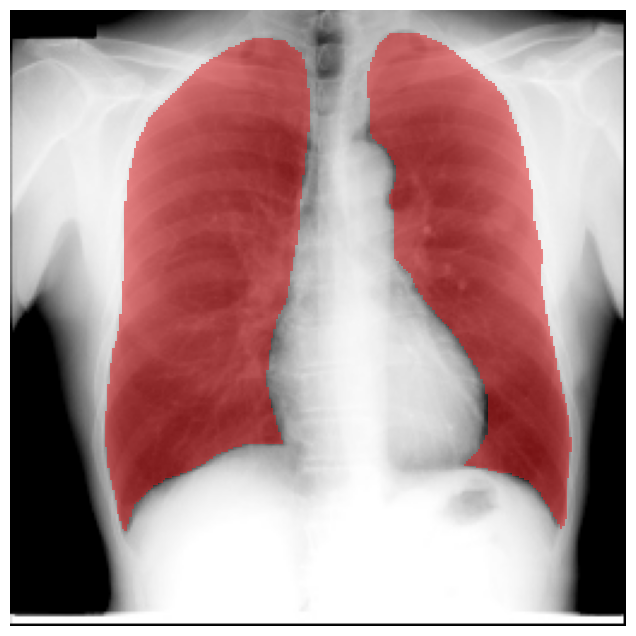

In [26]:
# Load train/val/test data
x_train, y_train, x_val, y_val, x_test, y_test = load_npz_dataset(data_fn)

# TODO:
# Bring images into the correct format for SAM:
# Image shape: (N, H, W, C=3)
# Mask shape: (N, H, W)
# Values: [0, 255] (uint8)

# YOUR CODE HERE
# Convert images and masks to SAM expected format
def to_sam_image(x):
    # x can be (N,H,W), (N,H,W,1), or already (N,H,W,3)
    if x is None:
        return None

    # Remove singleton channel if present
    if x.ndim == 4 and x.shape[-1] == 1:
        x = x[..., 0]  # (N,H,W)

    # Convert grayscale to RGB
    if x.ndim == 3:
        x = np.repeat(x[..., None], 3, axis=-1)  # (N,H,W,3)

    # Scale to [0,255] uint8
    x = x.astype(np.float32)

    # Common cases: images already in [0,255], or normalized to [0,1], or arbitrary float range
    x_min = float(np.min(x))
    x_max = float(np.max(x))

    if x_max <= 1.0 and x_min >= 0.0:
        x = x * 255.0
    elif not (0.0 <= x_min and x_max <= 255.0):
        x = map_interval(x, x_min, x_max, 0.0, 255.0)

    x = np.clip(x, 0.0, 255.0).astype(np.uint8)
    return x


def to_sam_mask(y):
    # y can be (N,H,W), (N,H,W,1) and might be float or uint8
    if y is None:
        return None

    if y.ndim == 4 and y.shape[-1] == 1:
        y = y[..., 0]

    # Ensure binary mask {0,1} as uint8
    y = (y > 0).astype(np.uint8)
    return y


x_train = to_sam_image(x_train)
x_val   = to_sam_image(x_val)
x_test  = to_sam_image(x_test)

y_train = to_sam_mask(y_train)
y_val   = to_sam_mask(y_val)
y_test  = to_sam_mask(y_test)


# your data should pass the following asserts
assert x_train.shape == (112, 256, 256, 3)
assert y_train.shape == (112, 256, 256)
assert x_val.shape == (12, 256, 256, 3)
assert y_val.shape == (12, 256, 256)
assert x_test.shape == (123, 256, 256, 3)
assert y_test.shape == (123, 256, 256)

assert x_train.dtype == y_train.dtype == np.uint8
assert np.min(x_train) == 0
assert np.max(x_train) == 255

# Plot an example
fig, ax = plot_image_with_segmentation(x_train[0], y_train[0])
plt.show()

# Single Example image

Let's try to run SAM on a single example image

In [30]:
example_img, example_mask = x_train[0], y_train[0]

predictor.set_image(example_img)

H, W = example_img.shape[:2]

input_points = np.array([
    [int(0.32 * W), int(0.55 * H)],  # left lung
    [int(0.68 * W), int(0.55 * H)],  # right lung
    [int(0.50 * W), int(0.12 * H)],  # negative point near top center
])

input_label = np.array([1, 1, 0])  # 1 = foreground, 0 = background

example_img.shape

(256, 256, 3)

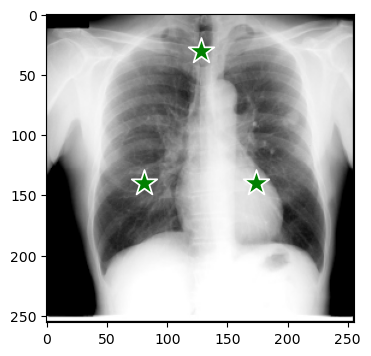

In [31]:
# Reshape input_points to ensure it is 2-dimensional
input_points = input_points.reshape(-1, 2)

fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(example_img)
ax.scatter(input_points[:, 0], input_points[:, 1], color='green', marker='*', s=375, edgecolor='white', linewidth=1.25)
plt.axis('on')
plt.show()

In [32]:
predictor.set_image(example_img)

masks, scores, logits = predictor.predict(
    point_coords=input_points,
    point_labels=input_label,
    multimask_output=True,
)

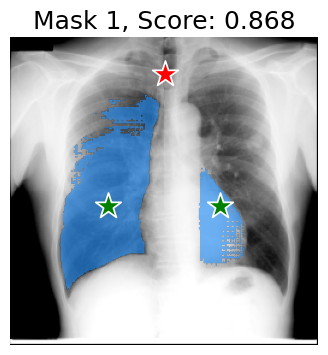

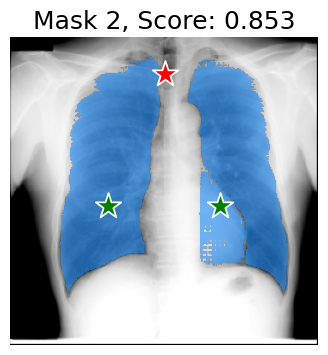

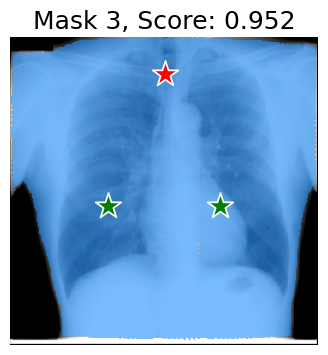

In [33]:
# Note that the "score" here is an estimation of the mask quality, not the quality of the segmentation compared to the ground truth.
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(4,4))
    plt.imshow(example_img.squeeze())
    show_mask(mask, plt.gca())
    show_points(input_points, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()

# Evaluation loop

In [ ]:
import torchmetrics
f1 = torchmetrics.F1Score(task="binary")

f1_scores = []

for img, mask_gt in zip(x_val, y_val):
    predictor.set_image(img)

    H, W = img.shape[:2]
    input_points = np.array([
        [int(0.32 * W), int(0.55 * H)],
        [int(0.68 * W), int(0.55 * H)],
        [int(0.50 * W), int(0.12 * H)],
    ])
    input_label = np.array([1, 1, 0])

    masks, scores, logits = predictor.predict(
        point_coords=input_points,
        point_labels=input_label,
        multimask_output=True
    )

    best_idx = int(np.argmax(scores))
    pred_mask = masks[best_idx].astype(np.uint8)
    gt_mask   = (mask_gt > 0).astype(np.uint8)

    pred_t = torch.from_numpy(pred_mask)
    gt_t   = torch.from_numpy(gt_mask)

    f1_val = f1(pred_t, gt_t).item()
    f1_scores.append(f1_val)

f1_scores = np.array(f1_scores, dtype=np.float32)

mean_f1 = float(np.mean(f1_scores))
std_f1  = float(np.std(f1_scores, ddof=1))

print(f"Mean F1 score: {mean_f1:.4f}")
print(f"Standard deviation: {std_f1:.4f}")

Mean F1 score: 0.5872
Standard deviation: 0.1643


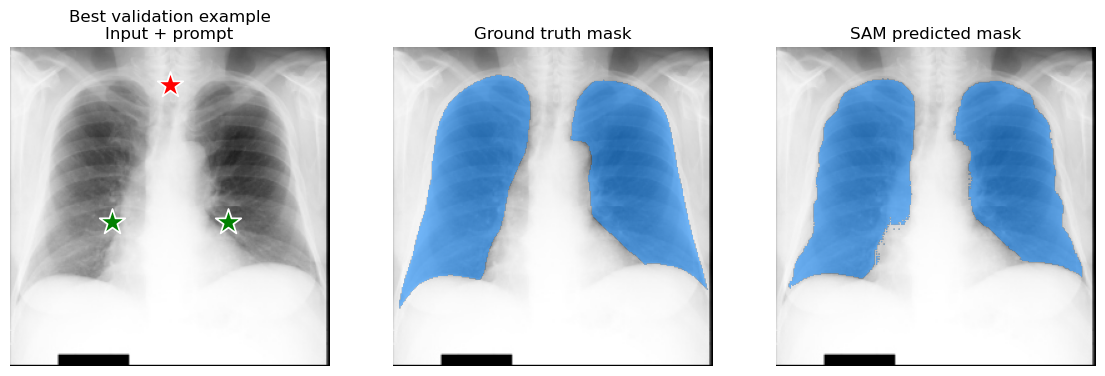

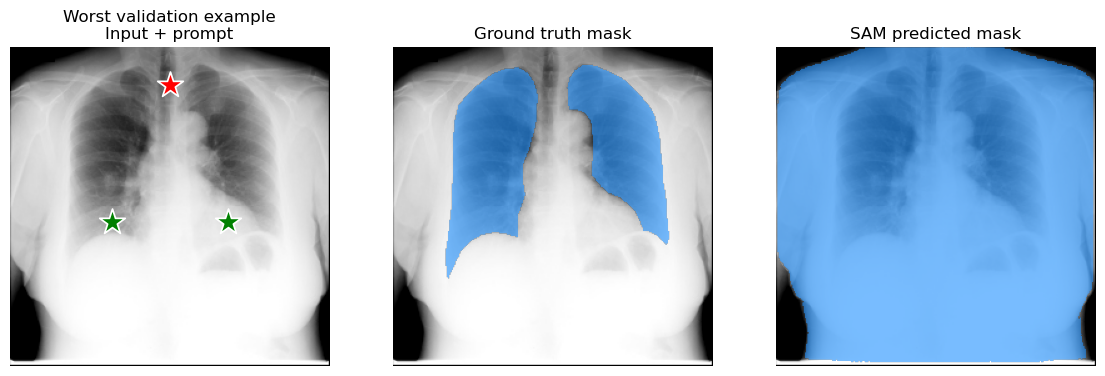

Best F1: 0.9256597 at index 3
Worst F1: 0.37974957 at index 0


In [ ]:
# Visualization of best and worst validation examples 
best_i = int(np.argmax(f1_scores))
worst_i = int(np.argmin(f1_scores))

for title, i in [("Best validation example", best_i), ("Worst validation example", worst_i)]:
    img = x_val[i]
    gt  = y_val[i]

    predictor.set_image(img)
    H, W = img.shape[:2]
    input_points = np.array([
        [int(0.32 * W), int(0.55 * H)],
        [int(0.68 * W), int(0.55 * H)],
        [int(0.50 * W), int(0.12 * H)],
    ])
    input_label = np.array([1, 1, 0])

    masks, scores, logits = predictor.predict(
        point_coords=input_points,
        point_labels=input_label,
        multimask_output=True
    )
    pred = masks[int(np.argmax(scores))].astype(np.uint8)

    fig = plt.figure(figsize=(14, 5))

    ax1 = fig.add_subplot(1, 3, 1)
    ax1.set_title(f"{title}\nInput + prompt")
    ax1.axis("off")
    ax1.imshow(img)
    show_points(input_points, input_label, ax1)

    ax2 = fig.add_subplot(1, 3, 2)
    ax2.set_title("Ground truth mask")
    ax2.axis("off")
    ax2.imshow(img)
    show_mask(gt[None, ...], ax2)

    ax3 = fig.add_subplot(1, 3, 3)
    ax3.set_title("SAM predicted mask")
    ax3.axis("off")
    ax3.imshow(img)
    show_mask(pred[None, ...], ax3)

    plt.show()

print("Best F1:", f1_scores[best_i], "at index", best_i)
print("Worst F1:", f1_scores[worst_i], "at index", worst_i)
